<a href="https://colab.research.google.com/github/InvestitoreComune/analisi_portafogli/blob/main/Ottimizzazione_Portafoglio_e_Frontiera_Efficiente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerie

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Input

✅ Creato da www.investitorecomune.it

📧 Per ogni segnalazione investitorecomune(at)gmail.com

In [ ]:
# seleziona i tickers del tuo portafoglio e le percentuali per strumento
tickers = ['SWDA.MI','EIMI.MI','SGLD.MI','XGLE.MI']
perc = [0.75, 0.05, 0.1, 0.1]

# seleziona periodo di analisi
anni = 15

# percentuali min/max per ottimizzazione
min = 0
max = 1

# seleziona risk free rate
risk_free_rate=0.026

# Elaborazione portafogli

In [ ]:
def rendimento(percentuali, log_returns):
  return np.sum(log_returns.mean()*percentuali) * 252

In [ ]:
def rendimento_negativo(percentuali, log_returns):
  return -rendimento(percentuali, log_returns)

In [ ]:
def deviazione_standard(percentuali, matrice_cov):
  return np.sqrt(percentuali.T @ matrice_cov @ percentuali)

In [ ]:
def sharpe(percentuali, log_returns, matrice_cov, risk_free_rate):
  return(rendimento(percentuali,log_returns)- risk_free_rate) / deviazione_standard (percentuali, matrice_cov)

In [ ]:
def sharpe_ratio_negativo(percentuali, log_returns, matrice_cov, risk_free_rate):
  return -sharpe(percentuali, log_returns, matrice_cov, risk_free_rate)

In [ ]:
def max_drawdown(returns):
    wealth = (1 + returns).cumprod()
    previous_peaks = wealth.cummax()
    drawdowns = (wealth - previous_peaks) / previous_peaks
    return np.min(drawdowns,axis=0)

In [ ]:
# funzione di massimizzazione dell'indice di sharpe
def max_sharpe(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(sharpe_ratio_negativo, np.array([1/len(tickers)]*len(tickers)), args=(log_returns, matrice_cov, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [ ]:
# funzione di minimizzazione della volatilità
def min_volatilita(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(deviazione_standard, np.array([1/len(tickers)]*len(tickers)), args=(matrice_cov), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [ ]:
# funzione di massimizzazione del rendimento
def max_rendimento(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(rendimento_negativo, np.array([1/len(tickers)]*len(tickers)), args=(log_returns), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [ ]:
# recupera prezzi adjusted
data_fine = dt.datetime.now()
data_inizio = data_fine - dt.timedelta(days=365*anni)
adjclose = yf.download(tickers, start=data_inizio, end=data_fine)['Adj Close']

# rendimenti
log_returns=np.log(adjclose/adjclose.shift(1)).dropna()
log_returns=log_returns.reindex(tickers,axis=1)

# covarianza
matrice_cov = log_returns.cov() * 252

[*********************100%***********************]  4 of 4 completed


In [ ]:
rendimento_portafoglio_attuale = rendimento(np.array(perc), log_returns)
volatilita_portafoglio_attuale = deviazione_standard(np.array(perc), matrice_cov)
sharpe_ratio_attuale = sharpe(np.array(perc), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_attuale = log_returns @ np.array(perc)
maxdd_portafoglio_attuale = max_drawdown(equity_line_portafoglio_attuale)

In [ ]:
rendimento_portafoglio_ottimale = rendimento(max_sharpe(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_ottimale = deviazione_standard(max_sharpe(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_ottimale = sharpe(max_sharpe(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_ottimale = log_returns @ max_sharpe(log_returns, matrice_cov, risk_free_rate)
maxdd_portafoglio_ottimale = max_drawdown(equity_line_portafoglio_ottimale)

In [ ]:
rendimento_portafoglio_minvol = rendimento(min_volatilita(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_minvol = deviazione_standard(min_volatilita(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_minvol = sharpe(min_volatilita(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_minvol = log_returns @ min_volatilita(log_returns, matrice_cov, risk_free_rate)
maxdd_portafoglio_minvol = max_drawdown(equity_line_portafoglio_minvol)

In [ ]:
rendimento_portafoglio_maxrend = rendimento(max_rendimento(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_maxrend = deviazione_standard(max_rendimento(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_maxrend = sharpe(max_rendimento(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_maxrend = log_returns @ max_rendimento(log_returns, matrice_cov, risk_free_rate)
maxdd_portafoglio_maxrend = max_drawdown(equity_line_portafoglio_maxrend)

In [ ]:
def StampaMetriche():
  # portafoglio attuale
  print("\033[4mMetriche di portafoglio attuale\033[0m")
  print(f"Rendimento Annuale atteso: {rendimento_portafoglio_attuale*100:.2f}%")
  print(f"Volatilita attesa: {volatilita_portafoglio_attuale*100:.2f}%")
  print(f"Indice di Sharpe atteso: {sharpe_ratio_attuale:.4f}")
  print(f"Max Drawdown: {maxdd_portafoglio_attuale*100:.2f}%")
  print("Asset Allocation:")
  for ticker, percentuale in zip(tickers,np.array(perc)):
    print(f"{ticker}: {percentuale*100:.1f}%")

  # portafoglio max sharpe
  print("\n\033[4mMetriche di portafoglio Max Sharpe\033[0m")
  print(f"Rendimento Annuale atteso: {rendimento_portafoglio_ottimale*100:.2f}%")
  print(f"Volatilita attesa: {volatilita_portafoglio_ottimale*100:.2f}%")
  print(f"Indice di Sharpe atteso: {sharpe_ratio_ottimale:.4f}")
  print(f"Max Drawdown: {maxdd_portafoglio_ottimale*100:.2f}%")
  print("Asset Allocation:")
  for ticker, percentuale in zip(tickers,max_sharpe(log_returns, matrice_cov, risk_free_rate)):
    print(f"{ticker}: {percentuale*100:.1f}%")

  # portafoglio min volatilita
  print("\n\033[4mMetriche di portafoglio Min Rischio\033[0m")
  print(f"Rendimento Annuale atteso: {rendimento_portafoglio_minvol*100:.2f}%")
  print(f"Volatilita attesa: {volatilita_portafoglio_minvol*100:.2f}%")
  print(f"Indice di Sharpe atteso: {sharpe_ratio_minvol:.4f}")
  print(f"Max Drawdown: {maxdd_portafoglio_minvol*100:.2f}%")
  print("Asset Allocation:")
  for ticker, percentuale in zip(tickers,min_volatilita(log_returns, matrice_cov, risk_free_rate)):
    print(f"{ticker}: {percentuale*100:.1f}%")

  # portafoglio max rendimento
  print("\n\033[4mMetriche di portafoglio Max Rendimento\033[0m")
  print(f"Rendimento Annuale atteso: {rendimento_portafoglio_maxrend*100:.2f}%")
  print(f"Volatilita attesa: {volatilita_portafoglio_maxrend*100:.2f}%")
  print(f"Indice di Sharpe atteso: {sharpe_ratio_maxrend:.4f}")
  print(f"Max Drawdown: {maxdd_portafoglio_maxrend*100:.2f}%")
  print("Asset Allocation:")
  for ticker, percentuale in zip(tickers,max_rendimento(log_returns, matrice_cov, risk_free_rate)):
    print(f"{ticker}: {percentuale*100:.1f}%")

# Elaborazione frontiera efficiente

In [ ]:
def portfolio_performance(percentuali, log_returns, matrice_cov):
  rend = rendimento(percentuali, log_returns)
  stdev = deviazione_standard(percentuali, matrice_cov)
  return rend, stdev

In [ ]:
def rend_portafoglio(percentuali, log_returns, matrice_cov):
  return portfolio_performance(percentuali, log_returns, matrice_cov)[0]

In [ ]:
def frontiera_efficiente(log_returns, matrice_cov, target, bound=(min,max)):
  constraints = ({'type':'eq','fun':lambda percentuali:rend_portafoglio(percentuali, log_returns, matrice_cov)-target},
                {'type':'eq','fun':lambda percentuali:np.sum(percentuali)-1})
  bounds = [bound for _ in range(len(tickers))]
  frontiera = minimize(deviazione_standard, np.array([1/len(tickers)]*len(tickers)), args=(matrice_cov), method='SLSQP', constraints=constraints, bounds=bounds)
  return frontiera

In [ ]:
def percentuali_efficienti(percentuali):
  df = pd.DataFrame(percentuali, index=log_returns.mean().index, columns=['allocazione'])
  return df

In [ ]:
def FrontieraEff(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  # portafoglio max sharpe
  act_portfolio = np.array(perc)
  act_rendimento = rendimento(act_portfolio, log_returns)
  act_deviazione_std = deviazione_standard(act_portfolio, matrice_cov)
  act_allocazione = pd.DataFrame(act_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  act_allocazione.allocazione = [round(i*100,0) for i in act_allocazione.allocazione]

  # portafoglio max sharpe
  maxSR_portfolio = max_sharpe(log_returns, matrice_cov, risk_free_rate)
  maxSR_rendimento = rendimento(maxSR_portfolio, log_returns)
  maxSR_deviazione_std = deviazione_standard(maxSR_portfolio, matrice_cov)
  maxSR_allocazione = pd.DataFrame(maxSR_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  maxSR_allocazione.allocazione = [round(i*100,0) for i in maxSR_allocazione.allocazione]

  # portafoglio min stdev
  minvol_portfolio = min_volatilita(log_returns, matrice_cov, risk_free_rate)
  minvol_rendimento = rendimento(minvol_portfolio, log_returns)
  minvol_deviazione_std = deviazione_standard(minvol_portfolio, matrice_cov)
  minvol_allocazione = pd.DataFrame(minvol_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  minvol_allocazione.allocazione = [round(i*100,0) for i in minvol_allocazione.allocazione]

  # portafoglio max rendimento
  maxrend_portfolio = max_rendimento(log_returns, matrice_cov, risk_free_rate)
  maxrend_rendimento = rendimento(maxrend_portfolio, log_returns)
  maxrend_deviazione_std = deviazione_standard(maxrend_portfolio, matrice_cov)
  maxrend_allocazione = pd.DataFrame(maxrend_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  maxrend_allocazione.allocazione = [round(i*100,0) for i in maxrend_allocazione.allocazione]

  # frontiera
  lista_efficienza = []
  perc_efficienti = []
  target = np.linspace(minvol_rendimento, maxrend_rendimento, 100)
  for tgt in target:
    lista_efficienza.append(frontiera_efficiente(log_returns, matrice_cov, tgt)['fun'])
    perc_efficienti.append(frontiera_efficiente(log_returns, matrice_cov, tgt)['x'])

  return act_rendimento, act_deviazione_std, act_allocazione, maxSR_rendimento, maxSR_deviazione_std, maxSR_allocazione, minvol_rendimento, minvol_deviazione_std, minvol_allocazione, maxrend_rendimento, maxrend_deviazione_std, maxrend_allocazione, np.array(lista_efficienza), target, np.array(perc_efficienti)

In [ ]:
def portafogli_eff(perc_efficienti):

  portafogli_efficienti = []
  for i in perc_efficienti:
    peff = pd.DataFrame(i, index=log_returns.mean().index, columns=['allocazione'])
    peff.allocazione = [round(i*100,0) for i in peff.allocazione]
    peff = peff.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')
    portafogli_efficienti.append(peff)

  return portafogli_efficienti

In [ ]:
def grafico_EF(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  act_rendimento, act_deviazione_std, act_allocazione, maxSR_rendimento, maxSR_deviazione_std, maxSR_allocazione, minvol_rendimento, minvol_deviazione_std, minvol_allocazione, maxrend_rendimento, maxrend_deviazione_std, maxrend_allocazione, lista_efficienza, target, perc_efficienti = FrontieraEff(log_returns, matrice_cov, risk_free_rate)

  act_rendimento = round(act_rendimento*100,2)
  act_deviazione_std = round(act_deviazione_std*100,2)
  maxSR_rendimento = round(maxSR_rendimento*100,2)
  maxSR_deviazione_std = round(maxSR_deviazione_std*100,2)
  minvol_rendimento = round(minvol_rendimento*100,2)
  minvol_deviazione_std = round(minvol_deviazione_std*100,2)
  maxrend_rendimento = round(maxrend_rendimento*100,2)
  maxrend_deviazione_std = round(maxrend_deviazione_std*100,2)
  target = [round(tg*100,2) for tg in target]
  lista_efficienza = [round(le*100,2) for le in lista_efficienza]
  portafogli_efficienti = portafogli_eff(perc_efficienti)

  # Portafoglio attuale
  ActPortfolio = go.Scatter(
      name='Portafoglio attuale',
      mode='markers',
      x=[act_deviazione_std],
      y=[act_rendimento],
      marker=dict(color='blue',size=12,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[act_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Max Sharpe Ratio
  MaxSharpe = go.Scatter(
      name='Max Sharpe Ratio',
      mode='markers',
      x=[maxSR_deviazione_std],
      y=[maxSR_rendimento],
      marker=dict(color='orange',size=12,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[maxSR_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Min Volatility
  MinVol = go.Scatter(
      name='Minor Rischio',
      mode='markers',
      x=[minvol_deviazione_std],
      y=[minvol_rendimento],
      marker=dict(color='green',size=8,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[minvol_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Max Rendimento
  MaxRend = go.Scatter(
      name='Massimo Rendimento',
      mode='markers',
      x=[maxrend_deviazione_std],
      y=[maxrend_rendimento],
      marker=dict(color='red',size=8,line=dict(width=1,color='black')),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=[maxrend_allocazione.to_string(index=True, header=False).replace('\n', ' ').replace('  ', ' ').replace('.0','%')]
  )

  # Frontiera Efficiente
  curvaEF = go.Scatter(
      name='',
      mode='lines',
      x=lista_efficienza,
      y=target,
      line=dict(color='black', width=2),
      hovertemplate='Allocazione: %{text}<br>Deviazione std: %{x}<br>Rendimento: %{y}',
      text=portafogli_efficienti
  )

  data = [curvaEF,ActPortfolio,MaxSharpe,MinVol,MaxRend]

  layout = go.Layout(
      title='Frontiera Efficiente',
      yaxis=dict(title='Rendimento annuale (%)'),
      xaxis=dict(title='Volatilita annuale (%)'),
      showlegend=False,
      #legend=dict(x=0.85,y=0,traceorder='normal',bgcolor='#E2E2E2',bordercolor='black',borderwidth=1),
      width=1200,
      height=800
  )

  fig=go.Figure(data=data, layout=layout)

  fig.show()

# Portafogli ottimali

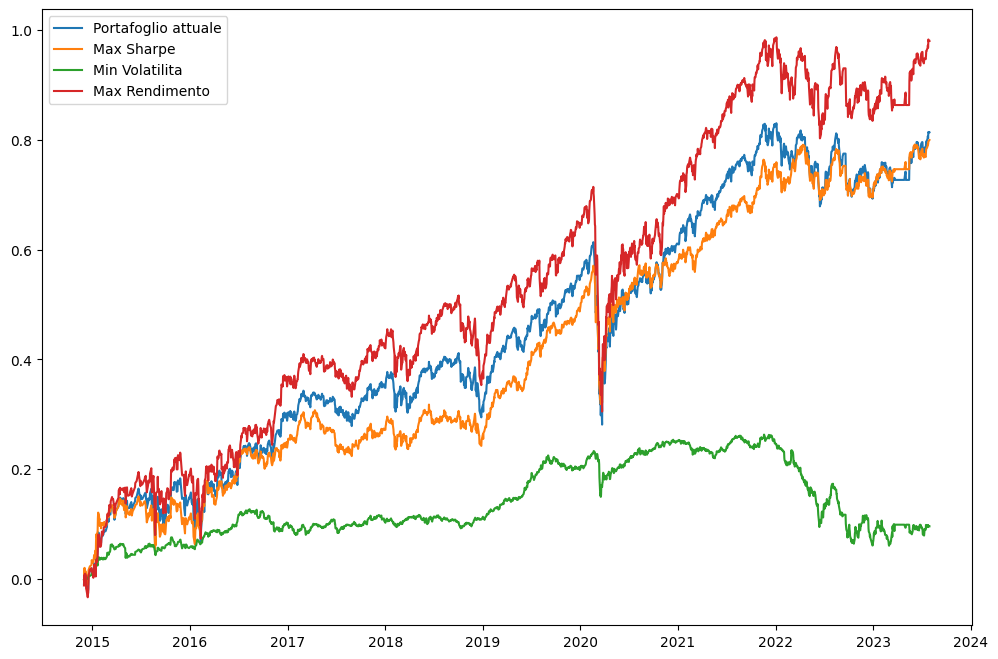

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(equity_line_portafoglio_attuale.cumsum(), label='Portafoglio attuale')
plt.plot(equity_line_portafoglio_ottimale.cumsum(), label='Max Sharpe')
plt.plot(equity_line_portafoglio_minvol.cumsum(), label = 'Min Volatilita')
plt.plot(equity_line_portafoglio_maxrend.cumsum(), label= 'Max Rendimento')
plt.legend()
plt.show()

In [ ]:
StampaMetriche()

Metriche di portafoglio attuale
Rendimento Annuale atteso: 9.73%
Volatilita attesa: 13.54%
Indice di Sharpe atteso: 0.5264
Max Drawdown: -29.00%
Asset Allocation:
SWDA.MI: 75.0%
EIMI.MI: 5.0%
SGLD.MI: 10.0%
XGLE.MI: 10.0%

Metriche di portafoglio Max Sharpe
Rendimento Annuale atteso: 9.56%
Volatilita attesa: 11.20%
Indice di Sharpe atteso: 0.6216
Max Drawdown: -22.78%
Asset Allocation:
SWDA.MI: 57.4%
EIMI.MI: 0.0%
SGLD.MI: 42.6%
XGLE.MI: 0.0%

Metriche di portafoglio Min Rischio
Rendimento Annuale atteso: 1.15%
Volatilita attesa: 5.10%
Indice di Sharpe atteso: -0.2845
Max Drawdown: -18.67%
Asset Allocation:
SWDA.MI: 9.0%
EIMI.MI: 0.0%
SGLD.MI: 5.4%
XGLE.MI: 85.5%

Metriche di portafoglio Max Rendimento
Rendimento Annuale atteso: 11.72%
Volatilita attesa: 16.84%
Indice di Sharpe atteso: 0.5412
Max Drawdown: -34.59%
Asset Allocation:
SWDA.MI: 100.0%
EIMI.MI: 0.0%
SGLD.MI: 0.0%
XGLE.MI: 0.0%


# Frontiera Efficiente

In [ ]:
grafico_EF(log_returns, matrice_cov, risk_free_rate)